In [35]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Random Forest

In [36]:
%%html

<a href="index.html" target="_self">Back to home page</a>

### Table of Contents

In [38]:
%%html

- <a href = '#rf'> Random Forest model </a>
<br>
- <a href = '#parameter'> Parameter optimization </a>
<br>
- <a href = '#best'> Best model </a>
<br>
- <a href = '#visualize'> Visualizing the performance of our model </a>
<br>
- <a href = '#features'> Most significant features </a>

-----------

In [18]:
import pandas as pd
import numpy as np
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn import covariance
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.decomposition import PCA 
import string
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import math
import string
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
## Loading Data 
test_data = pd.read_csv("test_imputed.csv")
train_data = pd.read_csv("train_imputed.csv")

In [5]:
## Separating our predictor and response variables 
x_train = train_data.drop(['zestimate_amount'],1)
y_train = train_data['zestimate_amount']
x_test = test_data.drop(['zestimate_amount'],1)
y_test = test_data['zestimate_amount']

<a id='rf'></a>
## Random Forest Model

It is likely that at least one of our features will not be linearly related to the house price estimate. Unfortunately, a linear based regression model would not effectively represent those relationships. Tree based models, however, can approximate non-linear relationships. Our implementation using random forests averages multiple decision trees trained on different parts of the training set to produce a housing price prediction. Similar to linear regression, we will use cross validation to prevent over fitting. We will also incorporate all the features in this model, rather than our set of "best features," as we did with linear and KNN regression because we believe random forests can better deal with insignificant features. 

<a id='parameter'></a>
## Parameter Optimization  

We considered applying Principal Component Analysis to reduce the number of features in our model to prevent overfitting. However, after implementing Random Forest with and without PCA, we noticed higher scores for our models without PCA. This is not surprising, given that the Random Forest method tends to do well with high dimensionality. 

We also tried various parameters for number of trees in the forest and maximum depth of the tree. We decided on ranges that are reasonable for the number of features and datapoints our model works with, and assuming that trees and depth will add accuracy in a decaying fashion. For number of trees in the forest, we explored parameters of 10, 30, 50, 70, and 90 and for maximum depth, we explored parameters of 10, 20, 30, 40, 50. 

In [9]:
# Parameters for tuning
n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(10, 50, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

In [11]:
# To keep track of the best model
best_score = 0
# Run grid search for model with 5-fold cross validation
#print '5-fold cross validation:'
for trees in n_trees:
    for depth in depths:
        # Cross validation for every experiment
        k_folds = cross_validation.KFold(x_train.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train.iloc[train_indices].values
            y_train_cv = y_train[train_indices].values
            # Generate validation data
            x_validate = x_train.iloc[validation_indices].values
            y_validate = y_train[validation_indices].values

            # Fit random forest on training data
            model = ensemble.RandomForestRegressor(n_estimators=trees, max_depth=depth)
            #model.fit(x_train_reduced, y_train_cv)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            #scores += [model.score(x_validate_reduced, y_validate)]
            scores += [model.score(x_validate, y_validate)]

            # Record and report accuracy
        average_score = np.mean(scores)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score

        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth


Trees: 10 Depth: 10 Score: 0.255802837443
Trees: 10 Depth: 20 Score: 0.366842332801
Trees: 10 Depth: 30 Score: 0.356330390885
Trees: 10 Depth: 40 Score: 0.311144808304
Trees: 30 Depth: 10 Score: 0.378658092278
Trees: 30 Depth: 20 Score: 0.371908583004
Trees: 30 Depth: 30 Score: 0.396277931664
Trees: 30 Depth: 40 Score: 0.372640119399
Trees: 50 Depth: 10 Score: 0.382655036282
Trees: 50 Depth: 20 Score: 0.380286631713
Trees: 50 Depth: 30 Score: 0.372799980021
Trees: 50 Depth: 40 Score: 0.404668227805
Trees: 70 Depth: 10 Score: 0.40186462328
Trees: 70 Depth: 20 Score: 0.418224515651
Trees: 70 Depth: 30 Score: 0.426981912915
Trees: 70 Depth: 40 Score: 0.386778948726
Trees: 90 Depth: 10 Score: 0.400655317246
Trees: 90 Depth: 20 Score: 0.403935914637
Trees: 90 Depth: 30 Score: 0.41484556033
Trees: 90 Depth: 40 Score: 0.456089748088


<a id='best'></a>
## Best Model 

The results of our optimization are as listed: 

In [13]:
# Fit model on entire train set using chosen number of trees and depth
model = ensemble.RandomForestRegressor(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_train, y_train)
print 'Chosen number of trees, depth:', best_trees, ',', best_depth
print 'Test accuracy:', model.score(x_test, y_test)

Chosen number of trees, depth: 90 , 40
Test accuracy: 0.533428082276


<a id='visualize'></a>
## Visualizing the performance of our model

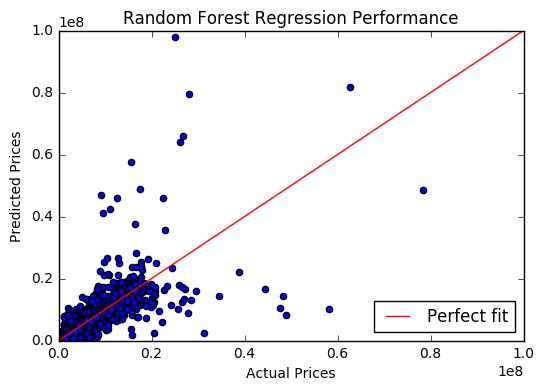

In [34]:
r2 = model.score(x_test, y_test) 

y_pred = model.predict(x_test)

fig, ax = plt.subplots(1, 1)

x = [0,100000000]
y = [0,100000000]

ax.scatter(y_pred, y_test, label = None)
ax.plot(x,y, color = 'red', label = "Perfect fit")
ax.set_xlim(0,100000000)
ax.set_ylim(0,100000000)

ax.legend(loc="lower right")
ax.set_title("Random Forest Regression Performance")
ax.set_xlabel("Actual Prices")
ax.set_ylabel("Predicted Prices")
plt.show()

As we can see, our model predicts fairly well for the lower price range that the majority of homes fall into, and gets worse for higher prices where there is less data.

<a id='features'></a>
## Most Significant Features

In [8]:
print "Top 10 Features sorted by their Score:"
#print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), x_train.columns), 
#             reverse=True)
sorted(zip(map(lambda x: round(x, 4), model.feature_importances_[0:10]), x_train.columns), reverse = True)

Top 10 Features sorted by their Score:


[(0.3549, 'home_size'),
 (0.0772, 'property_size'),
 (0.0624, 'latitude'),
 (0.0558, 'bathrooms'),
 (0.0522, 'longitude'),
 (0.0357, 'bedrooms'),
 (0.0266, 'year_built'),
 (0.0033, 'tax_year'),
 (0.0018, 'schools_Mean ELA Score'),
 (0.0014, 'schools_Number Tested')]

It is not suprising that these features were found to be the most significant. Home size, property size, bathrooms, and bedrooms are intrinsic characteristics of the property. Location, as represented by latitude and longitude, is also important since some neighborhoods are generally more desirable than others (Tribeca versus Washington Heights). Since quality of education is often cited as one of the top factors in the homebuying process, especially for those with children of the school-attending age, it is not suprising to see academic performance as a significant predictor. 

In [12]:
## Fitting model on whole data set 
#x = pd.concat([x_train, x_test])
#y = pd.concat([y_train, y_test]) 
#model = ensemble.RandomForestRegressor(n_estimators=best_trees, max_depth=best_depth)
#model.fit(x, y)

In [10]:
## Saving model to pickle file 
#import pickle
#s = pickle.dumps(model)
#pickle.dump(model, open("model.p", "wb"))

In [11]:
#model2 = pickle.load(open("model.p","rb"))